In [1]:
import torch

from TrainingFramework import TrainingFramework, plot_hist, end_of_hist_result
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Shallow/Wide Fully Connected architecture

In [11]:
class ShallowFC(nn.Module):
    
    def __init__(self, weight_sharing=False, auxiliary_loss=False):
        
        super(ShallowFC, self).__init__()
        
        self.input_size = 196
        self.output_pipe_size = 10
        self.output_classifier_size = 2
        
        self.weight_sharing = weight_sharing
        self.auxiliary_loss = auxiliary_loss
        
        # Create first pipe
        self.pipe1 = self.__create_pipe()

        # Depending on WS, create second pipe or use the same
        #self.pipe2 = self.pipe1 if self.weight_sharing is True else self.__create_pipe()
        if self.weight_sharing:
            self.pipe2 = self.pipe1
        else:
            self.pipe2 = self.__create_pipe()
            
        # Create final classifier
        self.classifier = self.__create_classifier()
        

    def forward(self, x):        
        x1 = x[:,0:1,:,:]
        x2 = x[:,1:2,:,:]
        
        x1_pipe = self.pipe1(x1.view(-1, self.input_size))
        x2_pipe = self.pipe2(x2.view(-1, self.input_size))
        
        x_main = torch.cat([x1_pipe, x2_pipe], dim=1)
        x_main = self.classifier(x_main)
        
        return x_main if self.auxiliary_loss is False else (x_main, (x1_pipe, x2_pipe))
  

    def __create_pipe(self): 
        return nn.Sequential(
                nn.Linear(self.input_size, 500),
                nn.ReLU(True),
                nn.Linear(500, self.output_pipe_size)
            )
    
    
    def __create_classifier(self):
        return nn.Sequential(
                nn.Linear(self.output_pipe_size * 2, 50),
                nn.ReLU(True),
                nn.Linear(50, self.output_classifier_size)
            )

### No weight sharing, no auxiliary loss

In [3]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hNN, tNN = tfNN.validateModel(ShallowFC)

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000760,1.0,0.791269,0.8256,NaN,NaN,NaN,NaN,49
best,0.001026,1.0,0.767621,0.8258,NaN,NaN,NaN,NaN,43


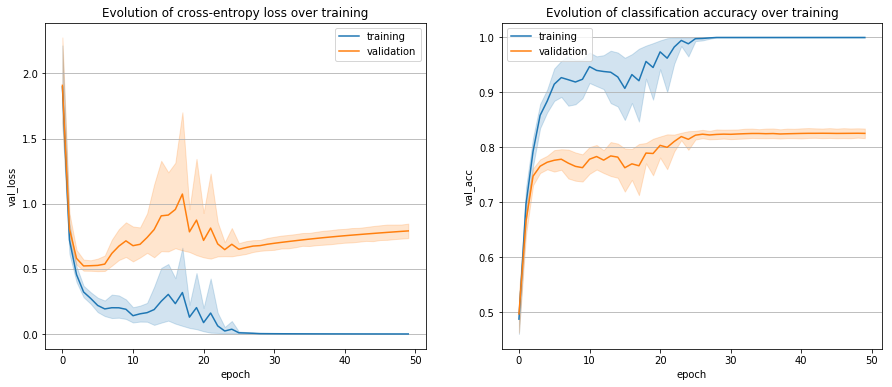

[7.205005469033495, 7.787045337958261, 7.4363168850541115, 7.017172342166305, 6.96050542104058, 7.7753573909867555, 7.551082183839753, 10.193931576097384, 8.099891863996163, 7.063355317804962]


In [4]:
hNN.to_csv('./histories/shallowFC_noWS_noAux.csv', encoding='utf-8')
plot_hist(hNN, auxloss=False)
print(tNN)

### Weight sharing, no auxiliary loss

In [5]:
tfYN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hYN, tYN = tfYN.validateModel(lambda: ShallowFC(weight_sharing=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000542,1.0,0.812828,0.8296,NaN,NaN,NaN,NaN,49
best,0.001325,1.0,0.731997,0.8313,NaN,NaN,NaN,NaN,33


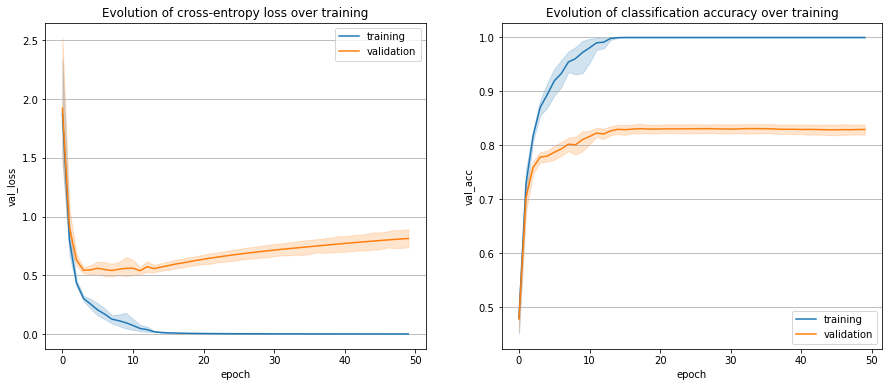

[6.292289766017348, 6.4370353179983795, 6.24227668880485, 6.42877022898756, 6.140688461018726, 6.385141627164558, 6.113957373891026, 6.397262722952291, 6.011607689084485, 6.307641350198537]


In [6]:
hYN.to_csv('./histories/shallowFC_yesWS_noAux.csv', encoding='utf-8')
plot_hist(hYN, auxloss=False)
print(tYN)

### No weight sharing, auxiliary loss

In [7]:
tfNY = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hNY, tNY = tfNY.validateModel(lambda: ShallowFC(auxiliary_loss=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.001757,1.0,0.654958,0.8293,0.000171,1.0,1.448732,0.8754,49
best,0.002137,1.0,0.642096,0.8293,0.000195,1.0,1.445245,0.8752,45


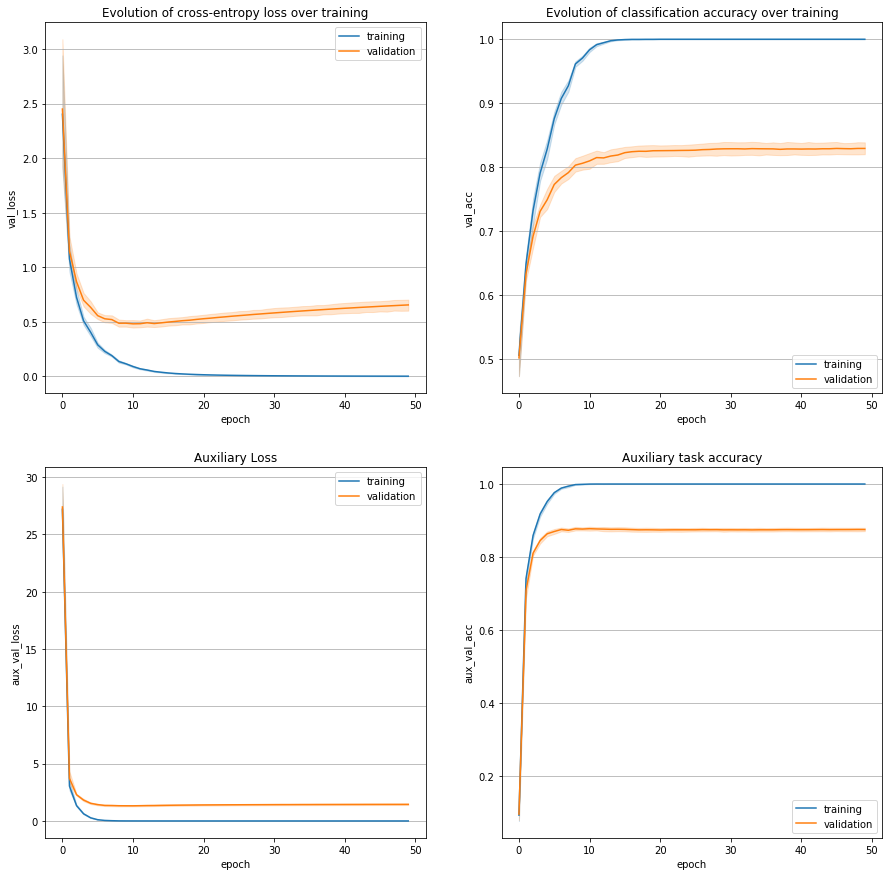

[12.510119539918378, 12.718365697888657, 10.023923923028633, 10.050965585978702, 10.32083955197595, 10.611081408103928, 10.31025642505847, 10.445680373813957, 10.820938833989203, 10.049917147029191]


In [8]:
hNY.to_csv('./histories/shallowFC_noWS_yesAux.csv', encoding='utf-8')
plot_hist(hNY, auxloss=True)
print(tNY)

### Weight sharing and auxiliary loss

In [9]:
tfYY = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hYY, tYY = tfYY.validateModel(lambda: ShallowFC(auxiliary_loss=True, weight_sharing=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.002228,1.0,0.613848,0.8392,0.000312,1.0,1.085322,0.89745,49
best,0.002473,1.0,0.607100,0.8393,0.000335,1.0,1.083563,0.89745,47


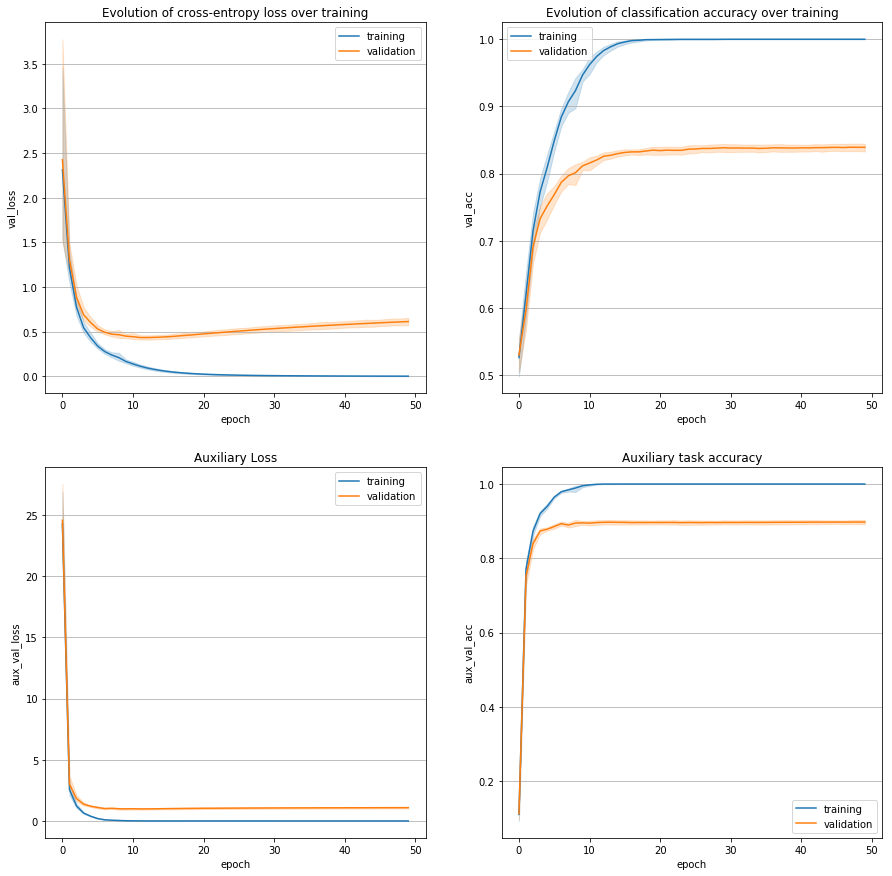

[9.672976734116673, 9.699028749018908, 9.791197383077815, 9.735991355963051, 9.173395986901596, 9.095425294013694, 9.02966564707458, 9.153672221116722, 9.00922842998989, 9.012980088824406]


In [10]:
hYY.to_csv('./histories/shallowFC_yesWS_yesAux.csv', encoding='utf-8')
plot_hist(hYY, auxloss=True)
print(tYY)